# NN with only Convolution Layers + LSTM for 1 Track Events (find track parameters)

In [1]:

# System imports
import math
from __future__ import print_function

# Standard imports
import sys
import numpy as np
from tempfile import TemporaryFile

# Python Externa Imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Keras Imports
from keras import models
from keras import layers
import keras.backend as K
from keras.regularizers import l2


# Local imports
from local_modules import generate_data, track_hit_coords, drawMulti_from_params_pix, drawMulti_from_params, get_Alist_pulls

# Magic
%matplotlib inline

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:04:00.0)


In [2]:
data = np.load('/bigdata/atsaris/new/data1trk.npz')

In [3]:
# Model
def build_model_2():
    """Test model.  Consists of several convolutional layers followed by dense layers and an output layer"""
    input_layer = layers.Input(shape=(1, num_det_layers, det_layer_size, det_layer_size))
    layer = layers.Convolution3D(8, 3, 3, 3, border_mode='same')(input_layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution3D(8, 3, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling3D(pool_size=(2,2,2))(layer)
    layer = layers.Convolution3D(16, 3, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution3D(16, 3, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Flatten()(layer)
    layer = layers.Dense(400)(layer)
    layer = layers.RepeatVector(max_tracks)(layer)
    layer = layers.LSTM(400, return_sequences=True)(layer)
    output_layer = layers.TimeDistributed(layers.Dense(4))(layer)
    model = models.Model(input=input_layer, output=output_layer)
    model.compile(loss='mean_squared_error', optimizer='Adam', sample_weight_mode="temporal", metrics=['accuracy'])
    return model

In [4]:
# Configuration
num_det_layers = data['num_det_layers']
det_layer_size = data['det_layer_size']
num_seed_layers = 0
avg_bkg_tracks = 0
noise_prob = 0.0
det_shape = (num_det_layers, det_layer_size, det_layer_size)

max_tracks = data['max_tracks']
num_tracks = data['num_tracks']

# Training parameters
batch_size = data['batch_size']
epoch_size = data['epoch_size']
num_epochs = data['num_epochs']


print(max_tracks, num_tracks, batch_size, epoch_size, num_epochs)

1 1 64 64000 10


In [5]:
# Train the model
model_2 = build_model_2()
history = model_2.fit(data['events'], data['target_slope'], batch_size=batch_size, nb_epoch=num_epochs, 
           validation_split=0.1, sample_weight=data['weights'])

Train on 57600 samples, validate on 6400 samples
Epoch 1/10
57600/57600 [==============================] - 57s - loss: 11.4118 - acc: 0.9393 - val_loss: 0.6097 - val_acc: 0.9641
Epoch 2/10
57600/57600 [==============================] - 34s - loss: 0.4742 - acc: 0.9713 - val_loss: 0.3404 - val_acc: 0.9712
Epoch 3/10
57600/57600 [==============================] - 32s - loss: 0.2603 - acc: 0.9761 - val_loss: 0.1757 - val_acc: 0.9798
Epoch 4/10
57600/57600 [==============================] - 65s - loss: 0.1269 - acc: 0.9833 - val_loss: 0.0729 - val_acc: 0.9898
Epoch 5/10
57600/57600 [==============================] - 71s - loss: 0.0462 - acc: 0.9893 - val_loss: 0.0379 - val_acc: 0.9923
Epoch 6/10
57600/57600 [==============================] - 70s - loss: 0.0348 - acc: 0.9900 - val_loss: 0.0375 - val_acc: 0.9917
Epoch 7/10
57600/57600 [==============================] - 56s - loss: 0.0314 - acc: 0.9908 - val_loss: 0.0302 - val_acc: 0.9927
Epoch 8/10
57600/57600 [==============================

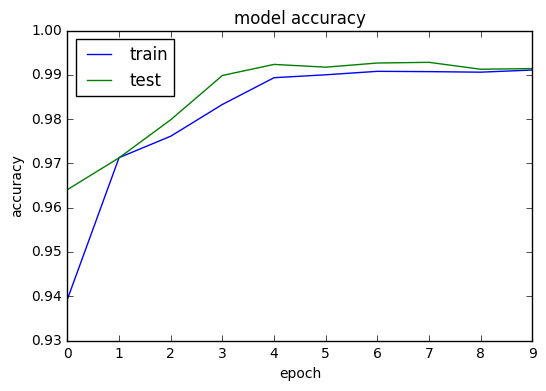

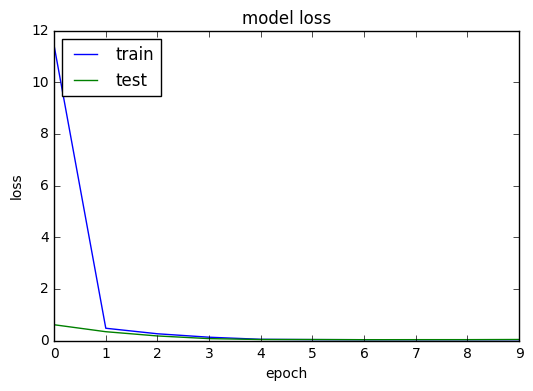

In [6]:
# Plot the accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [7]:
#test_data = np.load('/home/atsaris/hepTrack_newY_test/23_04_2017/test_data.npz')
test_data = np.load('/bigdata/atsaris/new/test1trk.npz')
train_events = test_data['events']
train_targets_slope = test_data['target_slope']
train_targets_slope_pix = test_data['target_slope_pix']
train_weights = test_data['weights']

In [8]:
#test_index = np.random.randint(0,test_data['epoch_size'])
test_index = np.random.randint(0,1000)
test_event = train_events[test_index]
test_weights = train_weights[test_index].astype(np.bool_)
test_a = train_targets_slope_pix[test_index][test_weights]
test_pred = model_2.predict(np.asarray([test_event]))[0][test_weights]

In [9]:
for i in range(0, 4):
    mu, sigma = get_Alist_pulls(model_2, 1000, train_events, train_weights, train_targets_slope, i, False)
    print("Param (μ, σ): ", mu, sigma)

Param (μ, σ):  -0.0383318914243 0.0670979288021
Param (μ, σ):  -0.0227360157072 0.0649902654081
Param (μ, σ):  0.151102215875 0.235446387657
Param (μ, σ):  0.0853760857246 0.243762122784


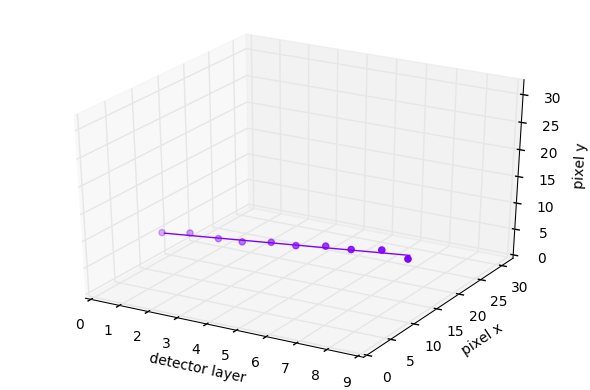

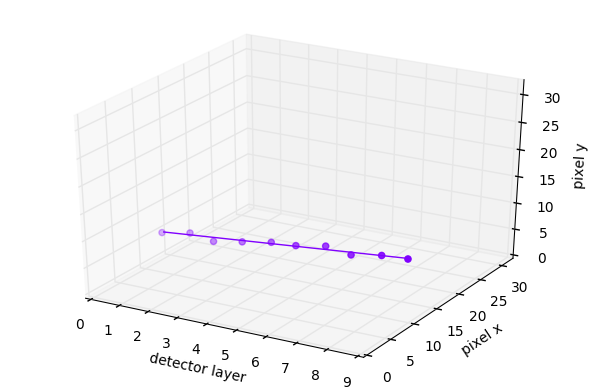

In [10]:
test_index = np.random.randint(0,test_data['epoch_size'])
test_event = train_events[test_index]
test_weights = train_weights[test_index].astype(np.bool_)
#test_a = train_targets_slope_pix[test_index][test_weights]
test_a = train_targets_slope[test_index][test_weights]
test_pred = model_2.predict(np.asarray([test_event]))[0][test_weights]
drawMulti_from_params_pix(num_tracks, test_a, num_det_layers, det_layer_size, True)
drawMulti_from_params_pix(num_tracks, test_pred, num_det_layers, det_layer_size, True)